# Kaggle Titanic Work

In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [2]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler

In [3]:
df = pd.read_csv('./data/train.csv')

In [4]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
df['Survived'] = df['Survived'].astype('bool')
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [7]:
df['Pclass'] = df['Pclass'].astype('category').cat.codes
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,True,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [8]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [9]:
def get_cabinletter(x):
    if type(x) == float:
        return np.NaN
    
    if x[:2] == 'F ':
        x = x[2:]
    
    return x[0]

df['CabinLetter'] = df['Cabin'].apply(get_cabinletter)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter
0,1,False,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN
1,2,True,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,True,2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN
3,4,True,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,False,2,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN


<Axes: xlabel='CabinLetter', ylabel='count'>

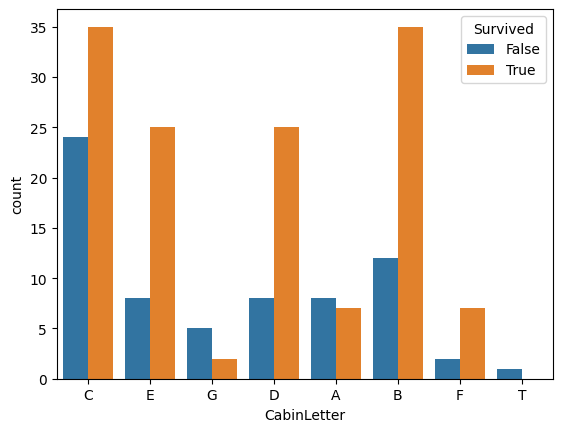

In [10]:
sns.countplot(df, hue='Survived', x='CabinLetter')

In [11]:
def get_cabin_count(x):
    if type(x) == float:
        return x
    if 'F ' in x:
        x = x[2:]
    s = [char for char in x.lower() if bool(re.search(r'[a-zA-Z]', char))]
    return len(s)

df['CabinCount'] = df['Cabin'].apply(get_cabin_count)
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter,CabinCount
0,1,False,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN
1,2,True,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1.0
2,3,True,2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN


In [12]:
def feature_extract_LastName(df):
    df['LastName'] = df['Name'].apply(lambda x: x.split(",")[0])
    return df

def feature_extract_Title(df):
    df['Title'] = df['Name'].str.extract(r',\s*([a-zA-Z]+.)', expand=True)
    return df

df = feature_extract_LastName(df)
df = feature_extract_Title(df)
df.head(1)

display(df['Title'].unique())

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.', 'the ',
       'Jonkheer.'], dtype=object)

In [13]:
def get_title(title):
    # Define subsets
    male_titles = ['Mr.', 'Don.', 'Sir.']
    male_young = ['Master.']
    female_married_ordinary = ['Mrs.', 'Mme.']
    female_unmarried_ordinary = ['Miss.', 'Mlle.', 'Ms.']
    nobility_female = ['Jonkheer.', 'the ', 'Lady.']
    navy = ['Col.', 'Capt.', 'Major.']
    profession = ['Rev.', 'Dr.']
    
    # Categorize titles
    if title in male_titles:
        return 'Male Titles'
    elif title in male_young:
        return 'Male Young'
    elif title in female_married_ordinary:
        return 'Female Ordinary'
    elif title in female_unmarried_ordinary:
        return 'Female High Status'
    elif title in nobility_female:
        return 'Female Nobility'
    elif title in navy:
        return 'Navy Title'
    elif title in profession:
        return 'Profession Title'
    else:
        return 'Unidentified'  # For titles that don't fit any category or if new types are added later
    
df['TitleEncoded'] = df['Title'].apply(get_title)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter,CabinCount,LastName,Title,TitleEncoded
0,1,False,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN,Braund,Mr.,Male Titles
1,2,True,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1.0,Cumings,Mrs.,Female Ordinary
2,3,True,2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN,Heikkinen,Miss.,Female High Status
3,4,True,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,1.0,Futrelle,Mrs.,Female Ordinary
4,5,False,2,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN,Allen,Mr.,Male Titles


In [14]:
df[df['Title'] == 'Unidentified']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter,CabinCount,LastName,Title,TitleEncoded


In [15]:
df['FamilySize'] = df['SibSp'] + df['Parch']

Best Score: 0.845125855250769
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


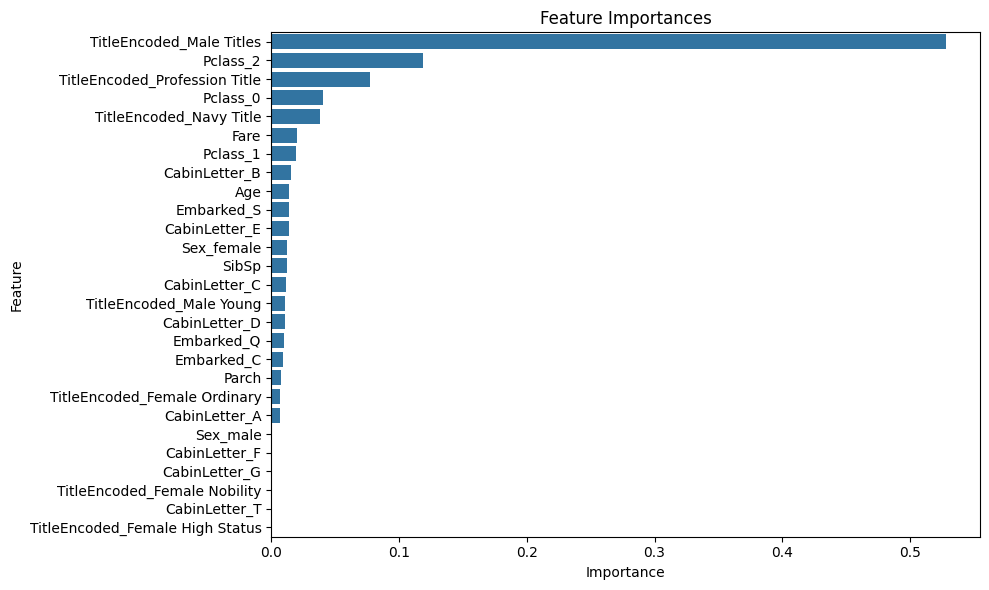

In [16]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'CabinLetter', 'TitleEncoded']
continuous_features = ['Age', 'SibSp', 'Parch', 'Fare']
target_feature = 'Survived'

df_train = df[categorical_features + continuous_features + [target_feature]]

X = df_train[categorical_features + continuous_features]
X = pd.get_dummies(X, columns=categorical_features)
y = df_train[target_feature]

X.head()

xgboost_params_grid = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
}

gridcv = GridSearchCV(XGBClassifier(random_state=42), param_grid=xgboost_params_grid, n_jobs=-1, cv=5)
gridcv.fit(X,y.values.ravel())

print(f"Best Score: {gridcv.best_score_}")
print(f"Best Model: {gridcv.best_estimator_}")

best_estimator = gridcv.best_estimator_
importances = best_estimator.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [17]:
# median_ages = df.groupby(['Pclass','TitleEncoded','Sex',])['Age'].transform('median')
# mean_ages = df.groupby(['Pclass','TitleEncoded','Sex',])['Age'].transform('mean')
# df['Age'] = df['Age'].fillna(median_ages)

<Axes: xlabel='Age', ylabel='Count'>

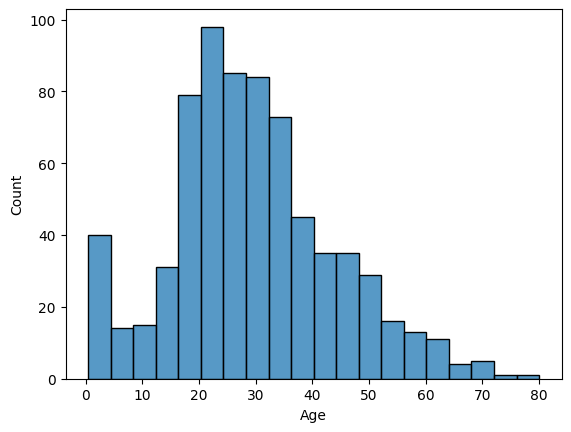

In [18]:
sns.histplot(df, x='Age')

In [19]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'CabinLetter',
       'CabinCount', 'LastName', 'Title', 'TitleEncoded', 'FamilySize'],
      dtype='object')

<Axes: xlabel='AgeTransform', ylabel='Count'>

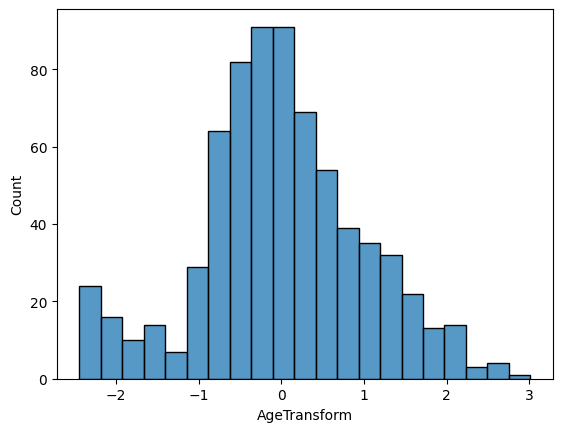

In [20]:
age_scaler = PowerTransformer('box-cox')
df['AgeTransform'] = age_scaler.fit_transform(df[['Age']])
sns.histplot(df, x='AgeTransform')

<Axes: xlabel='Fare', ylabel='Count'>

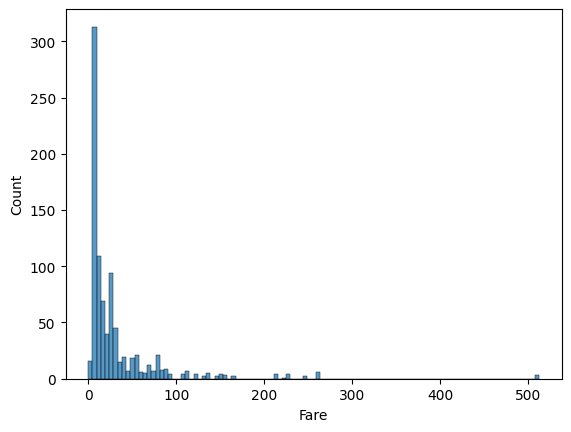

In [21]:
sns.histplot(df, x='Fare')

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 0 to 890
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   888 non-null    int64  
 1   Survived      888 non-null    bool   
 2   Pclass        888 non-null    int8   
 3   Name          888 non-null    object 
 4   Sex           888 non-null    object 
 5   Age           711 non-null    float64
 6   SibSp         888 non-null    int64  
 7   Parch         888 non-null    int64  
 8   Ticket        888 non-null    object 
 9   Fare          888 non-null    float64
 10  Cabin         202 non-null    object 
 11  Embarked      886 non-null    object 
 12  CabinLetter   202 non-null    object 
 13  CabinCount    202 non-null    float64
 14  LastName      888 non-null    object 
 15  Title         888 non-null    object 
 16  TitleEncoded  888 non-null    object 
 17  FamilySize    888 non-null    int64  
 18  AgeTransform  711 non-null    float

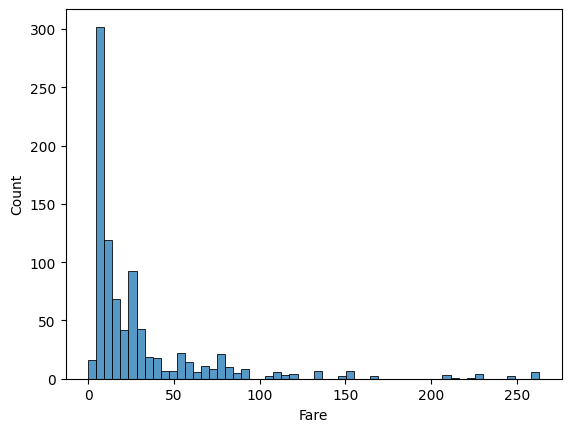

In [22]:
df = df[df['Fare'] <= 300]
sns.histplot(df, x='Fare')
df.info()

In [23]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinLetter,CabinCount,LastName,Title,TitleEncoded,FamilySize,AgeTransform
0,1,False,2,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN,Braund,Mr.,Male Titles,1,-0.468202
1,2,True,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,1.0,Cumings,Mrs.,Female Ordinary,1,0.604718
2,3,True,2,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN,Heikkinen,Miss.,Female High Status,0,-0.186302
3,4,True,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,1.0,Futrelle,Mrs.,Female Ordinary,1,0.413357
4,5,False,2,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN,Allen,Mr.,Male Titles,0,0.413357


<Axes: xlabel='FareTransform', ylabel='Count'>

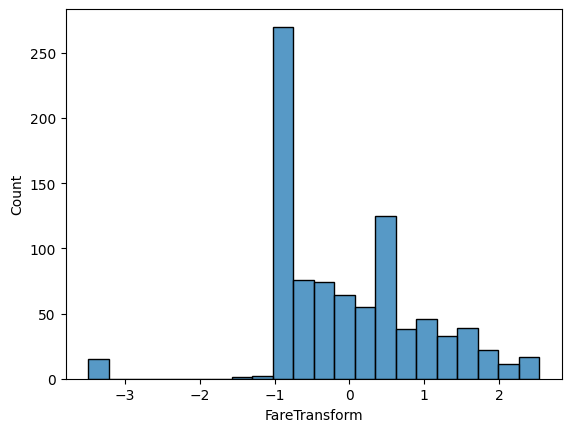

In [24]:
fare_transformer = PowerTransformer()
df['FareTransform'] = fare_transformer.fit_transform(df[['Fare']])
sns.histplot(df, x='FareTransform')

Best Score: 0.8524852409064941
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


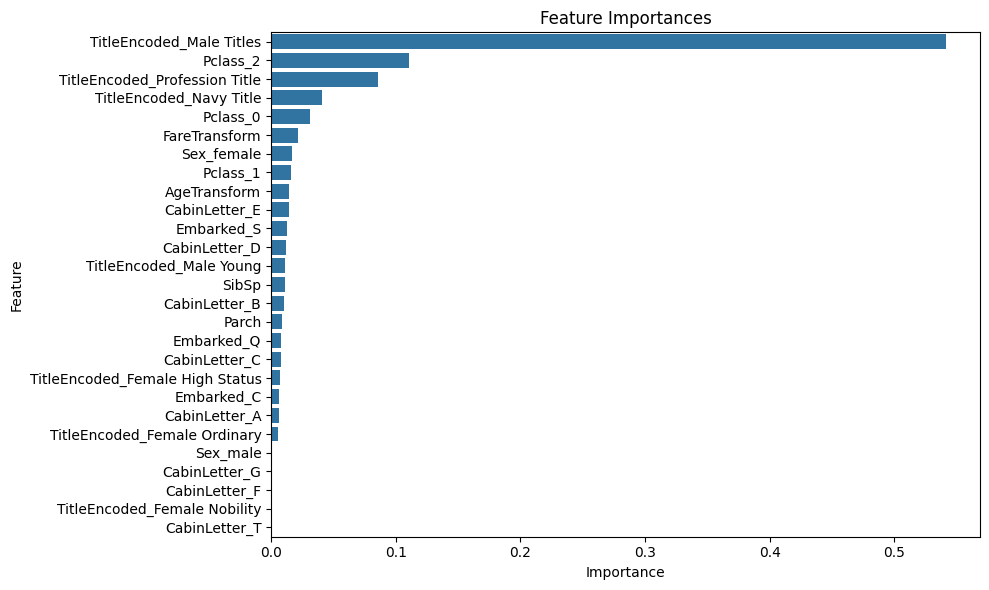

In [25]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'CabinLetter', 'TitleEncoded']
continuous_features = ['SibSp', 'Parch', 'AgeTransform', 'FareTransform', 'FamilySize', ']
target_feature = 'Survived'

df_train = df[categorical_features + continuous_features + [target_feature]]

X = df_train[categorical_features + continuous_features]
X = pd.get_dummies(X, columns=categorical_features)
y = df_train[target_feature]

X.head()

xgboost_params_grid = {
    'n_estimators': [200, 300, 400, 500, 600, 700, 800],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
}

gridcv = GridSearchCV(XGBClassifier(random_state=42), param_grid=xgboost_params_grid, n_jobs=-1, cv=5)
gridcv.fit(X,y.values.ravel())

print(f"Best Score: {gridcv.best_score_}")
print(f"Best Model: {gridcv.best_estimator_}")

best_estimator = gridcv.best_estimator_
importances = best_estimator.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()